<a href="https://colab.research.google.com/github/tural199823/pizza_not_pizza/blob/main/pizza_not_pizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pizza - Not Pizza classifier.

Below is a classifier with 0.9377 training and 0.8827 testing accuracy without using a pre-trained model. The model uses a set of simple Convolutional neural networks with batch normalization and dropout methods to reduce overfitting. Image augmentation was implemented due to low amount of different training data.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, MaxPooling2D, Flatten, Dropout, Activation
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/pnp.zip

In [ ]:
print(os.getcwd())

/content


In [ ]:
pizza_path = '../content/pizza_not_pizza/pizza'
not_pizza_path = '../content/pizza_not_pizza/not_pizza'
data_dir = '../content/pizza_not_pizza'

In [ ]:
num_pizza_images = len(os.listdir(pizza_path))
non_pizza_images = len(os.listdir(not_pizza_path))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

Number of Pizza images: 983
Number of Non-Pizza images: 983


In [ ]:
IMAGE_HEIGHT = 200
IMAGE_WIDTH = 200

In [ ]:
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip= True,
                              rotation_range = 20,
                              width_shift_range=0.2,
                              height_shift_range=0.2)

training_images = data_gen.flow_from_directory(data_dir,
                                          target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')

validation_images = data_gen.flow_from_directory(data_dir,
                                          target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
                                          batch_size = 32,
                                          subset = 'validation',
                                          class_mode = 'binary')

Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, 3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 200, 200, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 200, 200, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                        

In [ ]:
class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.88:
            print("\nReached 88% validation accuracy, so stopping training!")
            self.model.stop_training = True

accuracy_callback = AccuracyCallback()

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# I restarted training again after 80 epochs, so you can just set it up to 200 in advance, should work fine.
# The validation accuracy started at 0.5000 and slowly went up to 0.8827

In [ ]:
history = model.fit(training_images,
                    validation_data = validation_images,
                    epochs=80,
                    callbacks= [accuracy_callback],
                    verbose=1)

Epoch 1/80
50/50 [==============================] - 32s 642ms/step - loss: 0.2321 - accuracy: 0.9072 - val_loss: 0.5768 - val_accuracy: 0.8138
Epoch 2/80
50/50 [==============================] - 27s 532ms/step - loss: 0.2362 - accuracy: 0.9015 - val_loss: 0.4744 - val_accuracy: 0.8393
Epoch 3/80
50/50 [==============================] - 27s 534ms/step - loss: 0.2399 - accuracy: 0.8990 - val_loss: 0.3779 - val_accuracy: 0.8648
Epoch 4/80
50/50 [==============================] - 27s 533ms/step - loss: 0.2103 - accuracy: 0.9079 - val_loss: 0.4052 - val_accuracy: 0.8546
Epoch 5/80
50/50 [==============================] - 28s 569ms/step - loss: 0.2242 - accuracy: 0.9091 - val_loss: 0.7300 - val_accuracy: 0.7934
Epoch 6/80
50/50 [==============================] - 26s 517ms/step - loss: 0.2492 - accuracy: 0.9028 - val_loss: 0.6421 - val_accuracy: 0.8444
Epoch 7/80
50/50 [==============================] - 27s 533ms/step - loss: 0.2327 - accuracy: 0.9047 - val_loss: 0.4572 - val_accuracy: 0.8495

In [ ]:
import matplotlib.image as mpimg
def load_and_predict(model, num_images=20):
    uploaded_files = files.upload()

    count = 0
    for fn in uploaded_files.keys():
        if count >= num_images:
            break

        count += 1
        path = '/content/' + fn
        img = image.load_img(path, target_size=(200, 200))

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255.0

        classes = model.predict(x)
        prediction = "a pizza" if classes[0] > 0.5 else "not a pizza"

        # Display the image
        img = mpimg.imread(path)
        plt.imshow(img)
        plt.axis('off')

        # Display the prediction on top of the image
        plt.title(f'Prediction: {prediction}')
        plt.show()

        print(f'Image {count}: The model predicts that the image is {prediction}')


Saving plate-2802332_640.jpg to plate-2802332_640.jpg
Saving pizza-712667_640.jpg to pizza-712667_640.jpg
Saving pasta-1854245_640.jpg to pasta-1854245_640.jpg
Saving pasta-3547078_640.jpg to pasta-3547078_640.jpg
Saving pizza-329523_640.jpg to pizza-329523_640 (4).jpg
Saving pizza-2068272_640(1).jpg to pizza-2068272_640(1) (4).jpg
Saving pizza-6478478_640.jpg to pizza-6478478_640 (4).jpg
Saving pizza-397942_640.jpg to pizza-397942_640 (4).jpg
Saving pizza-2589575_640.jpg to pizza-2589575_640 (5).jpg
Saving pizza-1344720_640.jpg to pizza-1344720_640 (6).jpg
Saving salmon-518032_640.jpg to salmon-518032_640 (5).jpg
Saving vegetables-1085063_640.jpg to vegetables-1085063_640 (6).jpg
Saving vegetables-752153_640.jpg to vegetables-752153_640 (5).jpg
Saving soup-4055647_640.jpg to soup-4055647_640 (5).jpg
Saving cake-1971552_640(1).jpg to cake-1971552_640(1) (5).jpg
Saving cake-1850011_640.jpg to cake-1850011_640 (6).jpg
Saving cake-1971552_640.jpg to cake-1971552_640 (5).jpg
Saving spaghet

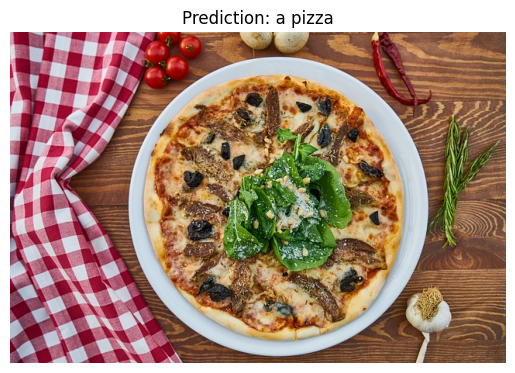

Image 1: The model predicts that the image is a pizza
1/1 [==============================] - 0s 32ms/step


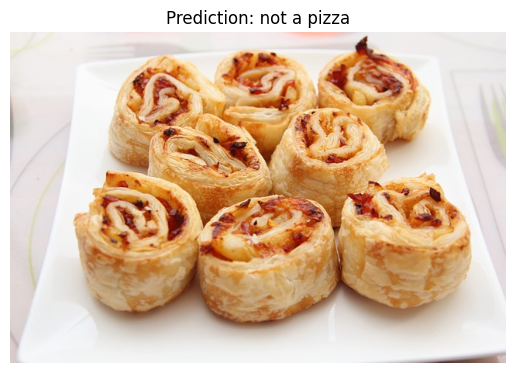

Image 2: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 29ms/step


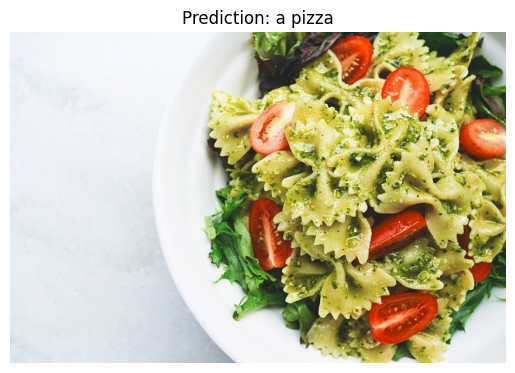

Image 3: The model predicts that the image is a pizza
1/1 [==============================] - 0s 26ms/step


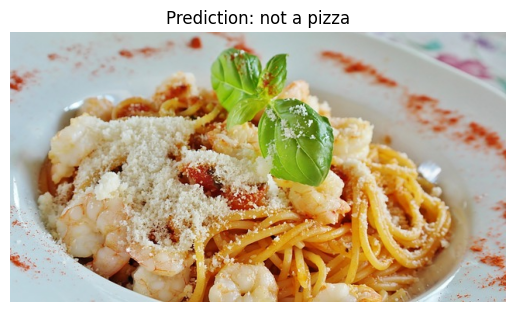

Image 4: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 28ms/step


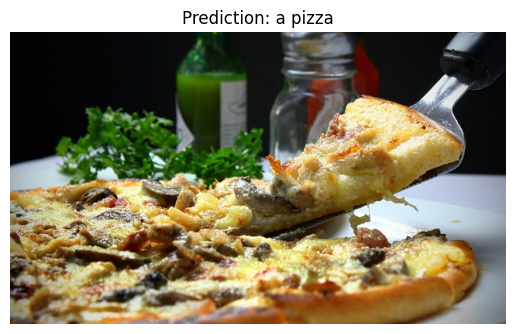

Image 5: The model predicts that the image is a pizza
1/1 [==============================] - 0s 34ms/step


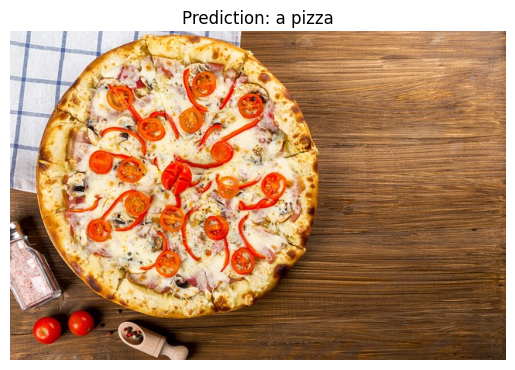

Image 6: The model predicts that the image is a pizza
1/1 [==============================] - 0s 60ms/step


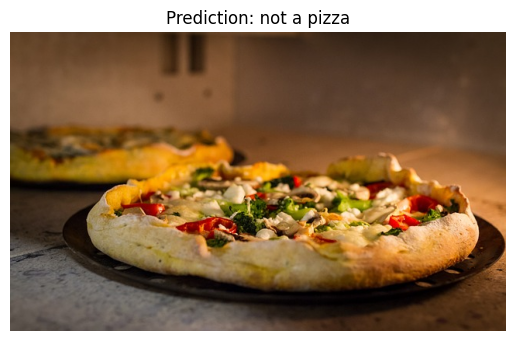

Image 7: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 25ms/step


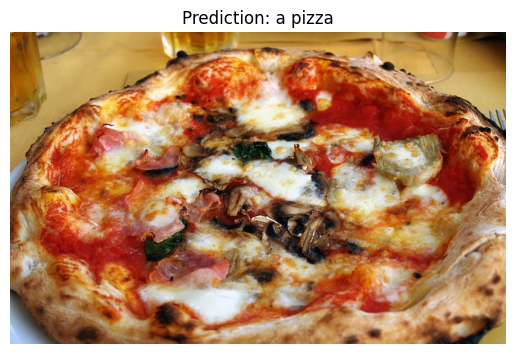

Image 8: The model predicts that the image is a pizza
1/1 [==============================] - 0s 50ms/step


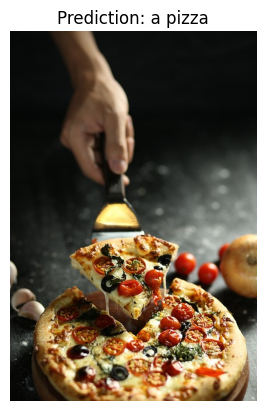

Image 9: The model predicts that the image is a pizza
1/1 [==============================] - 0s 38ms/step


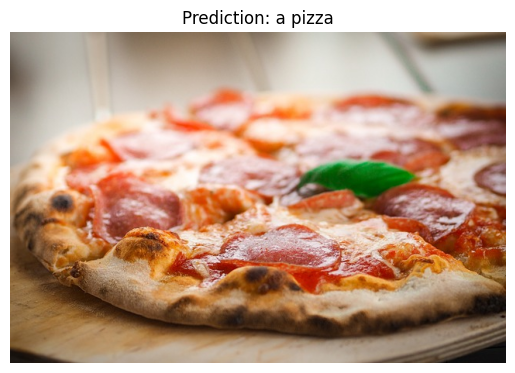

Image 10: The model predicts that the image is a pizza
1/1 [==============================] - 0s 34ms/step


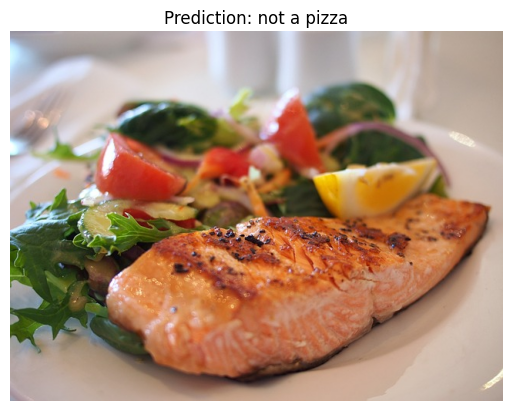

Image 11: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 31ms/step


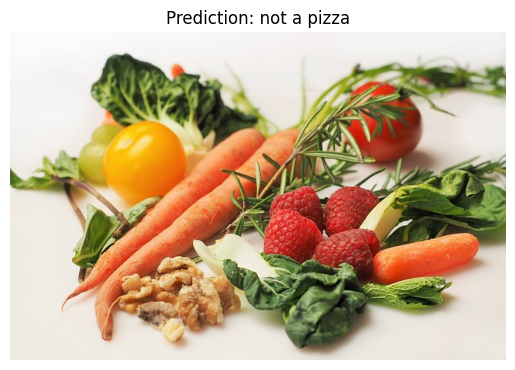

Image 12: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 57ms/step


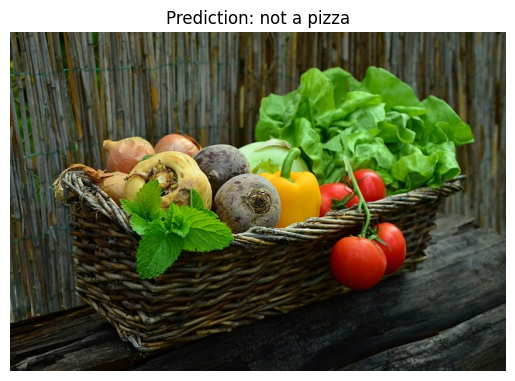

Image 13: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 41ms/step


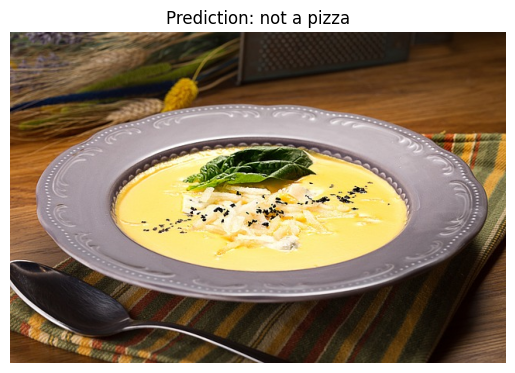

Image 14: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 26ms/step


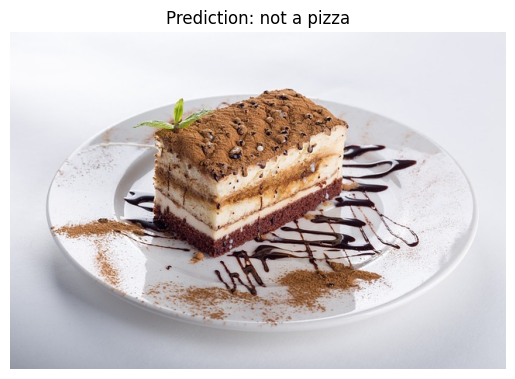

Image 15: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 27ms/step


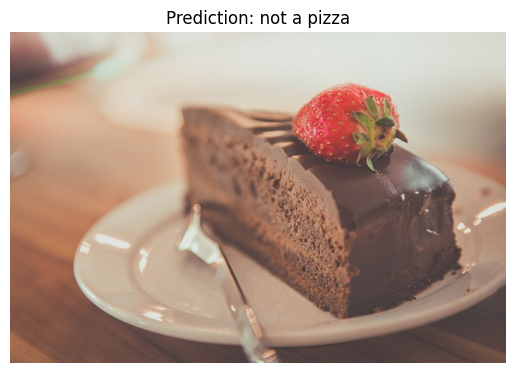

Image 16: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 28ms/step


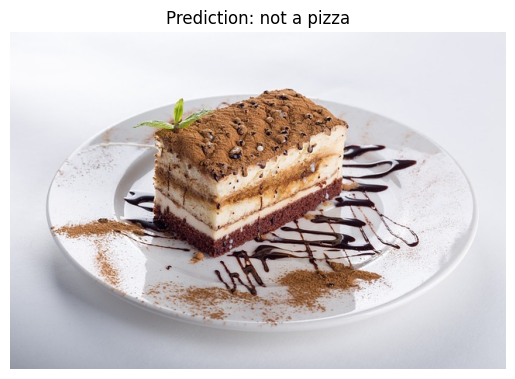

Image 17: The model predicts that the image is not a pizza
1/1 [==============================] - 0s 41ms/step


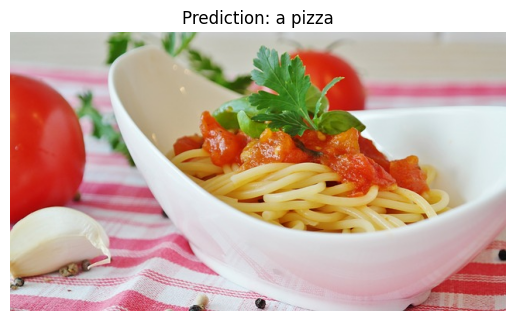

Image 18: The model predicts that the image is a pizza
1/1 [==============================] - 0s 36ms/step


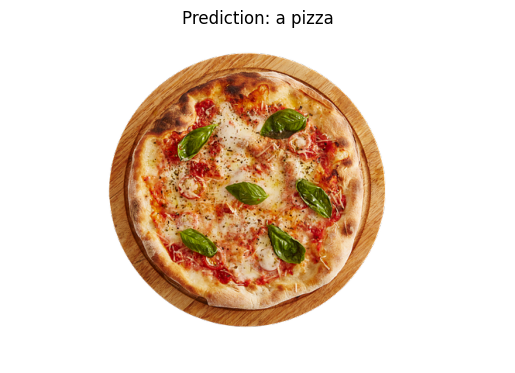

Image 19: The model predicts that the image is a pizza
1/1 [==============================] - 0s 25ms/step


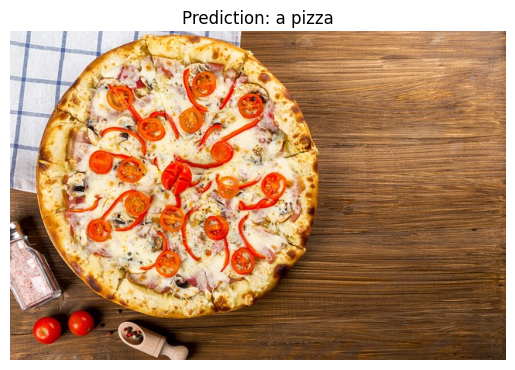

Image 20: The model predicts that the image is a pizza


In [ ]:
load_and_predict(model, num_images=20)